In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../")
DATA_PATH = '../data/'
data = pd.read_pickle(DATA_PATH + 'train_data.pkl')

## Data

In [2]:
# sample size
k = 1
data = data.sample(frac=k, random_state=137)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# scaling data
from data_pipeline import data_pipeline_3 as data_pipeline
from data_pipeline import dropFalseMCParticles

pipeline = data_pipeline()

unused_features = [
    'index',
    'has_MCParticle_not_electron',
    'is_downstream_reconstructible_not_electron',
    'is_true_seed',
    'seed_mva_value',
    'seed_nbIT',
    'seed_nLayers'
]

data = data.drop(unused_features, axis=1)
data = dropFalseMCParticles().fit_transform(data)
data = data.astype(np.float32)
data['is_downstream_reconstructible'] = data['is_downstream_reconstructible'].astype(np.int64)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1754766 entries, 1042314 to 3481
Data columns (total 9 columns):
is_downstream_reconstructible    int64
seed_chi2PerDoF                  float32
seed_p                           float32
seed_pt                          float32
seed_nLHCbIDs                    float32
seed_x                           float32
seed_y                           float32
seed_tx                          float32
seed_ty                          float32
dtypes: float32(8), int64(1)
memory usage: 80.3 MB


In [5]:
from sklearn.preprocessing import OneHotEncoder

def split_features(data):
    ohe_seed_nLHCbIDs = OneHotEncoder(35)
    seed_nLHCbIDs_one_hot = ohe_seed_nLHCbIDs.fit_transform(data['seed_nLHCbIDs'].values.reshape(-1,1)).todense()
    seed_nLHCbIDs_one_hot_df = pd.DataFrame(
        seed_nLHCbIDs_one_hot,
        columns=['_'.join(['seed_nLHCbIDs', str(i)]) for i in range(seed_nLHCbIDs_one_hot.shape[1])]
    )
    
#     ohe_seed_nbIT = OneHotEncoder(24)
#     seed_nbIT_one_hot = ohe_seed_nbIT.fit_transform(data['seed_nbIT'].values.reshape(-1,1)).todense()
#     seed_nbIT_one_hot_df = pd.DataFrame(
#         seed_nbIT_one_hot,
#         columns=['_'.join(['seed_nbIT', str(i)]) for i in range(seed_nbIT_one_hot.shape[1])]
#     )
    
#     ohe_seed_nLayers = OneHotEncoder(13)
#     seed_nLayers_one_hot = ohe_seed_nLayers.fit_transform(data['seed_nLayers'].values.reshape(-1,1)).todense()
#     seed_nLayers_one_hot_df = pd.DataFrame(
#         seed_nLayers_one_hot,
#         columns=['_'.join(['seed_nLayers', str(i)]) for i in range(seed_nLayers_one_hot.shape[1])]
#     )
    del data['seed_nLHCbIDs']
#     del data['seed_nbIT']
#     del data['seed_nLayers']
    
    return data, seed_nLHCbIDs_one_hot_df #, seed_nbIT_one_hot_df, seed_nLayers_one_hot_df

In [6]:
# split on train and test
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)

x_train = train_set.drop(['is_downstream_reconstructible'], axis=1)
x_train = pipeline.fit_transform(x_train)
y_train = train_set['is_downstream_reconstructible'].copy()

x_test = test_set.drop(['is_downstream_reconstructible'], axis=1)
x_test = pipeline.transform(x_test)
y_test = test_set['is_downstream_reconstructible'].copy()

In [7]:
# x_train, x_train_nLHCbIDs, x_train_nbIT, x_train_nLayers = split_features(x_train)
x_train, x_train_nLHCbIDs = split_features(x_train)

In [8]:
# x_test, x_test_nLHCbIDs, x_test_nbIT, x_test_nLayers = split_features(x_test)
x_test, x_test_nLHCbIDs = split_features(x_test)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6aff64dd68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6af587d4e0>]], dtype=object)

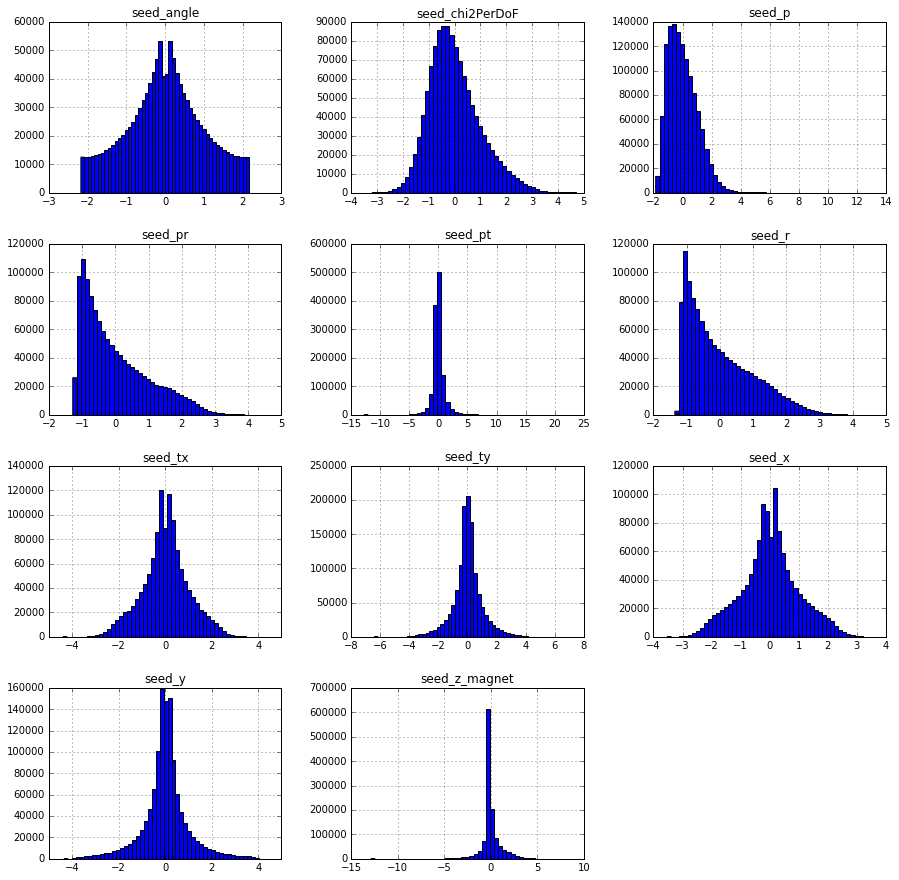

In [9]:
x_train.hist(bins=50, figsize=(15,15))

In [10]:
# from sklearn.preprocessing import QuantileTransformer
# qt = QuantileTransformer()
# x_train = pd.DataFrame(qt.fit_transform(x_train.values))
# x_test = pd.DataFrame(qt.transform(x_test.values))

## Model

In [11]:
from keras.wrappers.scikit_learn import KerasClassifier
import keras

from keras.layers.core import *
from keras.layers import *
from keras.models import Model
from keras.layers import BatchNormalization
import keras.backend as K

K.clear_session()

input_main = Input((x_test.shape[-1], ), name='main_input')
input_nLHCbIDs = Input((x_test_nLHCbIDs.shape[-1], ), name='nLHCbIDs_input')
# input_nbIT = Input((x_test_nbIT.shape[-1], ), name='nbIT_input')
# input_nLayers = Input((x_test_nLayers.shape[-1], ), name='nLayers_input')

encoding_dim = 2
n_neurons = 100
n_layers = 3
outputs = 2
dropout = 0.05
dense_nLHCbIDs = Dense(encoding_dim*4, activation='relu')(input_nLHCbIDs)
dense_nLHCbIDs = BatchNormalization()(dense_nLHCbIDs)
dense_nLHCbIDs = Dense(encoding_dim*2, activation='relu')(dense_nLHCbIDs)
dense_nLHCbIDs = BatchNormalization()(dense_nLHCbIDs)
dense_nLHCbIDs = Dense(encoding_dim, activation='relu')(dense_nLHCbIDs)
# dense_input_nbIT = Dense(encoding_dim, activation='relu')(input_nbIT)
# dense_nLayers = Dense(encoding_dim, activation='relu')(input_nLayers)

model = Concatenate()([
    input_main,
    dense_nLHCbIDs,
#     dense_input_nbIT,
#     dense_nLayers
])
for i in range(n_layers):
    model = Dense(n_neurons, activation='relu',)(model)
    model = Dropout(dropout)(model)
    model = BatchNormalization()(model)
    
output = Dense(outputs, activation='softmax')(model)
# model = Model(inputs=[input_main, input_nLHCbIDs, input_nbIT, input_nLayers], outputs=[output])
model = Model(inputs=[input_main, input_nLHCbIDs], outputs=[output])
model.compile('Adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
nLHCbIDs_input (InputLayer)      (None, 35)            0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 8)             288         nLHCbIDs_input[0][0]             
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 8)             32          dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 4)             36          batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [12]:
from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

In [13]:
model.fit(
#     x=[x_train.values, x_train_nLHCbIDs.values, x_train_nbIT.values, x_train_nLayers.values],
    x=[x_train.values, x_train_nLHCbIDs.values],
    y=y_train.values,
    epochs=8,
    validation_data=(
#         [x_test.values, x_test_nLHCbIDs.values, x_test_nbIT.values, x_test_nLayers.values],
        [x_test.values, x_test_nLHCbIDs.values],
        y_test.values
    ),
    class_weight=class_weight,
)

Train on 1228336 samples, validate on 526430 samples
Epoch 1/8
1228336/1228336 [==============================] - 288s - loss: 0.3833 - acc: 0.8389 - val_loss: 0.3421 - val_acc: 0.8664
Epoch 2/8
1228336/1228336 [==============================] - 261s - loss: 0.3531 - acc: 0.8571 - val_loss: 0.3348 - val_acc: 0.8685
Epoch 3/8
1228336/1228336 [==============================] - 298s - loss: 0.3458 - acc: 0.8606 - val_loss: 0.3231 - val_acc: 0.8762
Epoch 4/8
1228336/1228336 [==============================] - 230s - loss: 0.3410 - acc: 0.8635 - val_loss: 0.3298 - val_acc: 0.8733
Epoch 5/8
1228336/1228336 [==============================] - 213s - loss: 0.3381 - acc: 0.8651 - val_loss: 0.3195 - val_acc: 0.8780
Epoch 6/8
1228336/1228336 [==============================] - 318s - loss: 0.3364 - acc: 0.8660 - val_loss: 0.3246 - val_acc: 0.8767
Epoch 7/8
1228336/1228336 [==============================] - 308s - loss: 0.3343 - acc: 0.8666 - val_loss: 0.3360 - val_acc: 0.8718
Epoch 8/8
1228336/12283

In [14]:
def get_classes(predictions_proba):
    return np.argmax(predictions_proba, axis=1)

In [15]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [16]:
# accuracy_score(y_train.values, get_classes(model.predict([x_train.values, x_train_nLHCbIDs.values, x_train_nbIT.values, x_train_nLayers.values])))

# accuracy_score(y_test.values, get_classes(model.predict([x_test.values, x_test_nLHCbIDs.values, x_test_nbIT.values, x_test_nLayers.values])))

# roc_auc_score(y_train.values, model.predict([x_train.values, x_train_nLHCbIDs.values, x_train_nbIT.values, x_train_nLayers.values])[:,1])

# roc_auc_score(y_test.values, model.predict([x_test.values, x_test_nLHCbIDs.values, x_test_nbIT.values, x_test_nLayers.values])[:,1])

In [17]:
print(accuracy_score(y_train.values, get_classes(model.predict([x_train.values, x_train_nLHCbIDs.values]))))
print(accuracy_score(y_test.values, get_classes(model.predict([x_test.values, x_test_nLHCbIDs.values]))))

print(roc_auc_score(y_train.values, model.predict([x_train.values, x_train_nLHCbIDs.values])[:,1]))

print(roc_auc_score(y_test.values, model.predict([x_test.values, x_test_nLHCbIDs.values])[:,1]))

0.873796746167
0.8738331782
0.928684668413
0.928362745074


In [18]:
for name, step in pipeline.named_steps.items():
    print(step)
    try:
        print(step.scaler.scale_)
        print('std: ', step.scaler.scale_)
        print('mean: ', step.scaler.mean_)
    except Exception as e:
            pass

addPR()
[ 0.17856324]
std:  [ 0.17856324]
mean:  [ 0.22914613]
txScale()
[ 0.29576847]
std:  [ 0.29576847]
mean:  [-0.00422249]
addAngle()
[ 0.72259562]
std:  [ 0.72259562]
mean:  [ 0.00140145]
addR()
[ 519.91120035]
std:  [ 519.91120035]
mean:  [ 707.61042581]
addZ()
[ 0.04334942]
std:  [ 0.04334942]
mean:  [ 0.57604572]
tyScale()
[ 0.06486862]
std:  [ 0.06486862]
mean:  [ 0.00013073]
ptScale()
[ 0.20677143]
std:  [ 0.20677143]
mean:  [ 3.08250979]
chi2PerDoFScaler()
[ 0.37649142]
std:  [ 0.37649142]
mean:  [ 1.23350879]
xScale()
[ 718.45885408]
std:  [ 718.45885408]
mean:  [-3.58761813]
yScale()
[ 504.799883]
std:  [ 504.799883]
mean:  [ 1.0987292]
pScale()
[ 0.44031953]
std:  [ 0.44031953]
mean:  [ 3.89077256]


In [19]:
model.save('../saved_models/keras_discrete_encoding_model_3.h5')

In [20]:
K.clear_session()